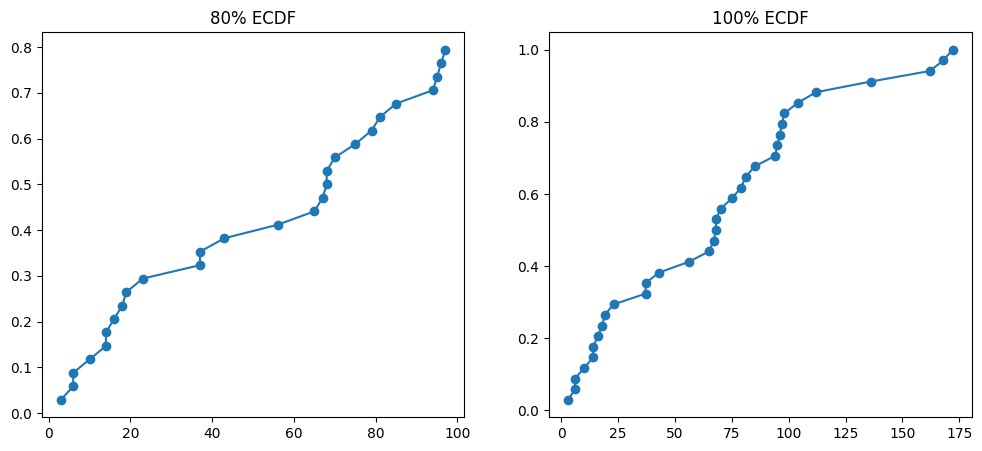

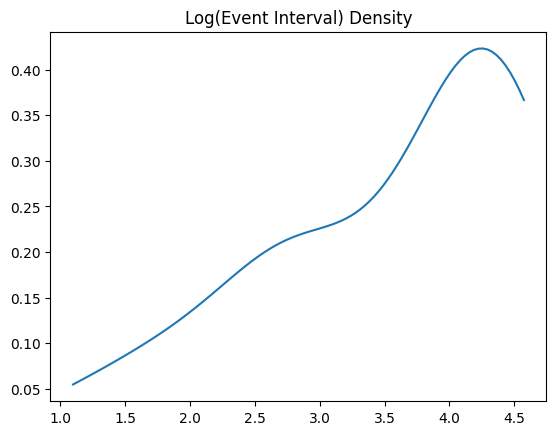

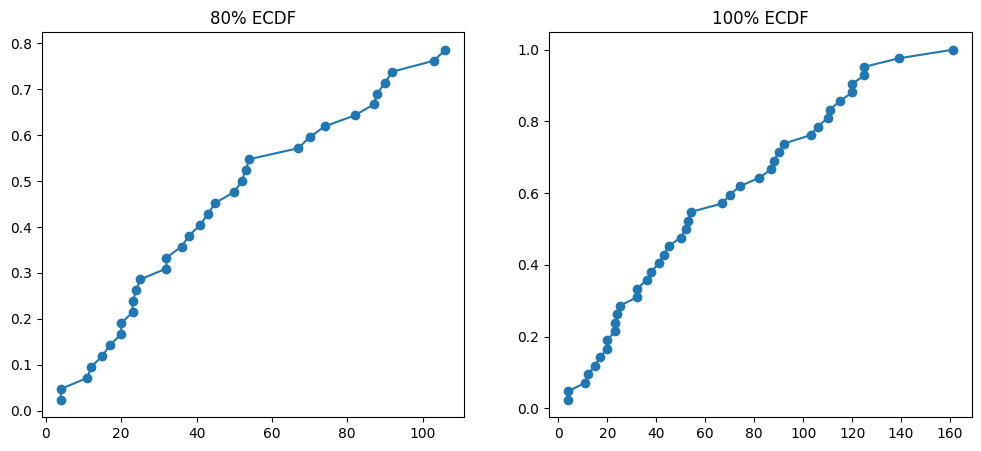

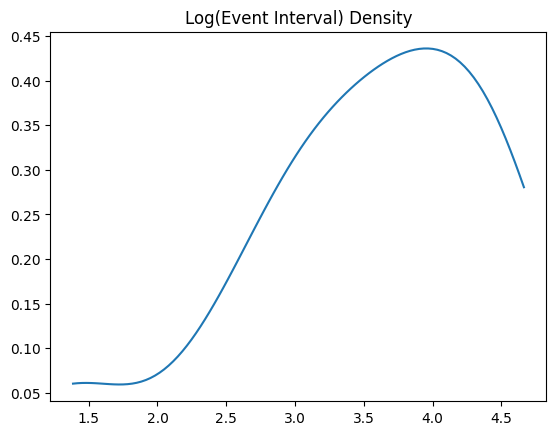

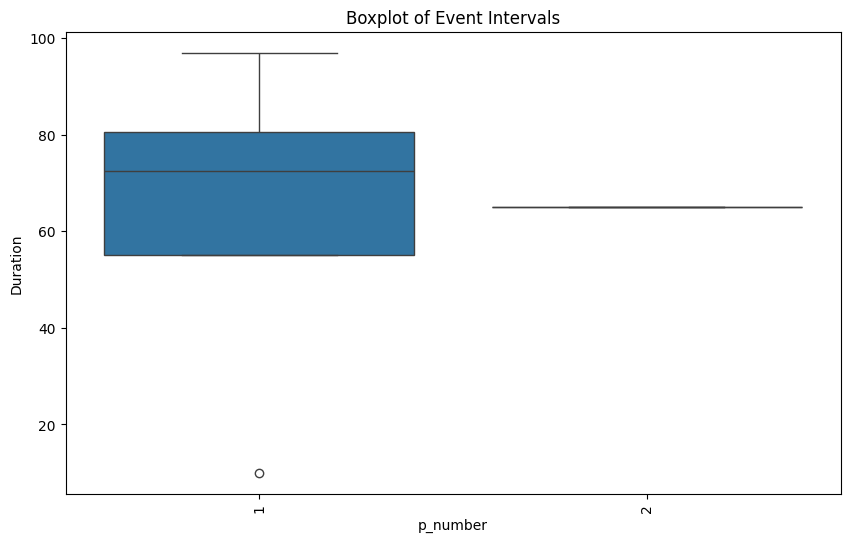

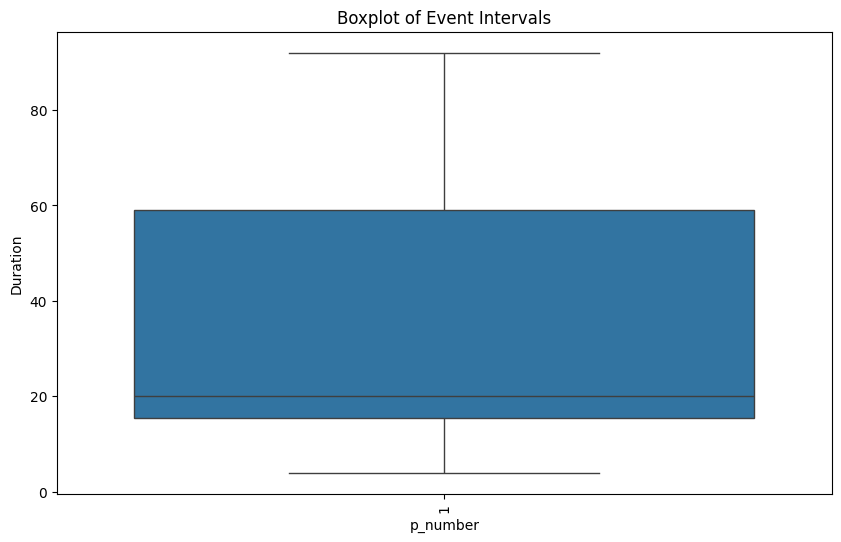

,pnr,eksd,Median,cluster,prev_eksd,Duration,p_number
112,1,2020-04-22,25.0,0,2020-04-02,20,1
199,13,2020-07-18,87.5,1,2020-04-17,92,1
86,49,2020-03-27,25.0,0,2020-02-20,36,1
166,50,2020-06-15,87.5,1,2020-03-25,82,1
147,58,2020-05-27,25.0,0,2020-05-23,4,1
195,62,2020-07-14,25.0,0,2020-06-24,20,1
121,71,2020-05-01,25.0,0,2020-04-20,11,1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Sample Data
# Replace 'med_events' with your actual dataset
med_events = pd.DataFrame({
    "pnr": np.random.randint(1, 100, 200),
    "eksd": pd.date_range(start='1/1/2020', periods=200, freq='D'),
    "perday": np.random.randint(1, 5, 200),
    "ATC": np.random.choice(['medA', 'medB'], 200),
    "dur_original": np.random.randint(1, 30, 200)
})

def see(med_events, arg1):
    df = med_events[med_events['ATC'] == arg1].copy()
    df = df.sort_values(by=['pnr', 'eksd'])
    df['prev_eksd'] = df.groupby('pnr')['eksd'].shift(1)
    df = df.dropna()
    df['event_interval'] = (df['eksd'] - df['prev_eksd']).dt.days
    
    # Empirical CDF
    sorted_intervals = np.sort(df['event_interval'].values)
    cdf = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    df_cdf = pd.DataFrame({'x': sorted_intervals, 'y': cdf})
    df_cdf = df_cdf[df_cdf['y'] <= 0.8]
    
    # Plot CDF
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_cdf['x'], df_cdf['y'], marker='o')
    plt.title("80% ECDF")
    plt.subplot(1, 2, 2)
    plt.plot(sorted_intervals, cdf, marker='o')
    plt.title("100% ECDF")
    plt.show()
    
    max_interval = df_cdf['x'].max()
    df = df[df['event_interval'] <= max_interval]
    
    # Density Plot
    log_intervals = np.log(df['event_interval'])
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_vals = density(x_vals)
    
    plt.figure()
    plt.plot(x_vals, y_vals)
    plt.title("Log(Event Interval) Density")
    plt.show()
    
    # Clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_cdf[['x', 'y']])
    silhouette_scores = []
    
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(scaled_data)
        silhouette_scores.append(silhouette_score(scaled_data, labels))
    
    best_k = np.argmax(silhouette_scores) + 2
    kmeans = KMeans(n_clusters=best_k, random_state=1234)
    df_cdf['cluster'] = kmeans.fit_predict(df_cdf[['x']])
    
    # Assign Cluster to Event Intervals
    df['cluster'] = df['event_interval'].apply(lambda x: df_cdf[df_cdf['x'] >= x]['cluster'].min() if len(df_cdf[df_cdf['x'] >= x]) > 0 else 0)
    df['Median'] = df.groupby('cluster')['event_interval'].transform('median')
    
    return df[['pnr', 'eksd', 'Median', 'cluster']]

def see_assumption(df):
    df = df.sort_values(by=['pnr', 'eksd'])
    df['prev_eksd'] = df.groupby('pnr')['eksd'].shift(1)
    df = df.dropna()
    df['Duration'] = (df['eksd'] - df['prev_eksd']).dt.days
    df['p_number'] = df.groupby('pnr').cumcount() + 1
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['p_number'], y=df['Duration'])
    plt.title("Boxplot of Event Intervals")
    plt.xticks(rotation=90)
    plt.show()
    
    return df

medA = see(med_events, "medA")
medB = see(med_events, "medB")
see_assumption(medA)
see_assumption(medB)